In [1]:
import os
import sys
sys.path.append(r'modules')
import aicspylibczi
import imgfileutils as imf
import visutools as vt
import czi_tools as czt
import itertools as it
from tqdm import tqdm, trange
from tqdm.contrib.itertools import product
import pandas as pd
import numpy as np
import dateutil.parser as dt
import matplotlib.pyplot as plt
import plotly
import plotly.offline as pyo

In [2]:
def save_planetable(df, filename, separator=',', index=True):
    """Save dataframe as CSV table

    :param df: Dataframe to be saved as CSV.
    :type df: pd.DataFrame
    :param filename: filename of the CSV to be written
    :type filename: str
    :param separator: seperator for the CSV file, defaults to ','
    :type separator: str, optional
    :param index: option write the index into the CSV file, defaults to True
    :type index: bool, optional
    :return: filename of the csvfile that was written
    :rtype: str
    """
    csvfile = os.path.splitext(filename)[0] + '_planetable.csv'

    # write the CSV data table
    df.to_csv(csvfile, sep=separator, index=index)

    return csvfile

In [3]:
def define_czi_planetable():

    df = pd.DataFrame(columns=['Subblock',
                               'Scene',
                               'Tile',
                               'T',
                               'Z',
                               'C',
                               'X [micron]',
                               'Y [micron]',
                               'Z [micron]',
                               'Time [s]',
                               'xstart',
                               'ystart',
                               'xwidth',
                               'ywidth'])

    return df

In [4]:
def filterplanetable(planetable, S=0, T=0, Z=0, C=0):

    # filter planetable for specific scene
    if S > planetable['Scene'].max():
        print('Scene Index was invalid. Using Scene = 0.')
        S = 0
    pt = planetable[planetable['Scene'] == S]

    # filter planetable for specific timepoint
    if T > planetable['T'].max():
        print('Time Index was invalid. Using T = 0.')
        T = 0
    pt = planetable[planetable['T'] == T]

    # filter resulting planetable pt for a specific z-plane
    if Z > planetable['Z [micron]'].max():
        print('Z-Plane Index was invalid. Using Z = 0.')
        zplane = 0
    pt = pt[pt['Z [micron]'] == Z]

    # filter planetable for specific channel
    if C > planetable['C'].max():
        print('Channel Index was invalid. Using C = 0.')
        C = 0
    pt = planetable[planetable['C'] == C]

    # return filtered planetable
    return pt

In [5]:
def get_czi_planetable(czifile):

    # get the czi object using pylibczi
    czi = aicspylibczi.CziFile(czifile)

    # get the czi metadata
    md, add = imf.get_metadata(czifile)

    # initialize the plane table
    df_czi = define_czi_planetable()

    # define subblock counter
    sbcount = -1

    # in case the CZI has the M-Dimension
    if md['czi_isMosaic']:

        for s, m, t, z, c in product(range(md['SizeS']),
                                     range(md['SizeM']),
                                     range(md['SizeT']),
                                     range(md['SizeZ']),
                                     range(md['SizeC'])):

            sbcount += 1
            # print(s, m, t, z, c)
            info = czi.read_subblock_rect(S=s, M=m, T=t, Z=z, C=c)

            # read information from subblock
            sb = czi.read_subblock_metadata(unified_xml=True,
                                            B=0,
                                            S=s,
                                            M=m,
                                            T=t,
                                            Z=z,
                                            C=c)

            try:
                time = sb.xpath('//AcquisitionTime')[0].text
                timestamp = dt.parse(time).timestamp()
            except IndexError as e:
                timestamp = 0.0

            try:
                xpos = np.double(sb.xpath('//StageXPosition')[0].text)
            except IndexError as e:
                xpos = 0.0

            try:
                ypos = np.double(sb.xpath('//StageYPosition')[0].text)
            except IndexError as e:
                ypos = 0.0

            try:
                zpos = np.double(sb.xpath('//FocusPosition')[0].text)
            except IndexError as e:
                zpos = 0.0

            df_czi = df_czi.append({'Subblock': sbcount,
                                    'Scene': s,
                                    'Tile': m,
                                    'T': t,
                                    'Z': z,
                                    'C': c,
                                    'X [micron]': xpos,
                                    'Y [micron]': ypos,
                                    'Z [micron]': zpos,
                                    'Time [s]': timestamp,
                                    'xstart': info[0],
                                    'ystart': info[1],
                                    'xwidth': info[2],
                                    'ywidth': info[3]},
                                   ignore_index=True)

    if not md['czi_isMosaic']:

        for s, t, z, c in product(range(md['SizeS']),
                                  range(md['SizeT']),
                                  range(md['SizeZ']),
                                  range(md['SizeC'])):

            sbcount += 1
            info = czi.read_subblock_rect(S=s, T=t, Z=z, C=c)

            # read information from subblocks
            sb = czi.read_subblock_metadata(unified_xml=True, B=0, S=s, T=t, Z=z, C=c)

            try:
                time = sb.xpath('//AcquisitionTime')[0].text
                timestamp = dt.parse(time).timestamp()
            except IndexError as e:
                timestamp = 0.0

            try:
                xpos = np.double(sb.xpath('//StageXPosition')[0].text)
            except IndexError as e:
                xpos = 0.0

            try:
                ypos = np.double(sb.xpath('//StageYPosition')[0].text)
            except IndexError as e:
                ypos = 0.0

            try:
                zpos = np.double(sb.xpath('//FocusPosition')[0].text)
            except IndexError as e:
                zpos = 0.0

            df_czi = df_czi.append({'Subblock': sbcount,
                                    'Scene': s,
                                    'Tile': 0,
                                    'T': t,
                                    'Z': z,
                                    'C': c,
                                    'X [micron]': xpos,
                                    'Y [micron]': ypos,
                                    'Z [micron]': zpos,
                                    'Time [s]': timestamp,
                                    'xstart': info[0],
                                    'ystart': info[1],
                                    'xwidth': info[2],
                                    'ywidth': info[3]},
                                   ignore_index=True)

    # normalize timestamps
    df_czi = imf.norm_columns(df_czi, colname='Time [s]', mode='min')

    # cast data  types
    df_czi = df_czi.astype({'Subblock': 'int32',
                            'Scene': 'int32',
                            'Tile': 'int32',
                            'T': 'int32',
                            'Z': 'int32',
                            'C': 'int16',
                            'xstart': 'int32',
                            'xstart': 'int32',
                            'ystart': 'int32',
                            'xwidth': 'int32',
                            'ywidth': 'int32'},
                           copy=False,
                           errors='ignore')

    return df_czi

In [14]:
filepath = r"testdata\testwell96_DAPI_small.czi"
#filepath = r"testdata\testwell96_PlaneTable.csv"

# define dimension indices
S=0
T=0
Z=0
C=0

# get the planetable
if filepath.lower().endswith('.czi'):
    planetable = get_czi_planetable(filepath)
    
if filepath.lower().endswith('.csv'):
    planetable = pd.read_csv(filepath, sep=',')
    

# filter the planetable for S, T, Z and C entry
planetable_filtered = filterplanetable(planetable, S=S, T=T, Z=Z, C=C)

Detected Image Type (based on extension):  czi


C:\ProgramData\Anaconda3\envs\imageanalysis\lib\site-packages\aicsimageio\transforms.py:178: UserWarning:

Data has dimension B with depth 1, assuming B=0 is the desired value, if not the case specify B=x where x is an integer, list, tuple, range, or slice.



Trying to extract Scene and Well information if existing ...


 34%|███████████████████████████▊                                                     | 33/96 [00:00<00:00, 323.53it/s]

Scales will not be rounded.


100%|█████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 284.02it/s]


In [15]:
# show the dataframe
planetable_filtered[:5]

,Subblock,Scene,Tile,T,Z,C,X [micron],Y [micron],Z [micron],Time [s],xstart,ystart,xwidth,ywidth
0,0,0,0,0,0,0,4261.284,8361.406,683.000,0.000000,168,0,320,320
1,1,1,0,0,0,0,13293.666,8372.441,683.934,2.376136,19926,24,320,320
2,2,2,0,0,0,0,22326.052,8383.476,679.075,4.746271,39684,49,320,320
3,3,3,0,0,0,0,31358.388,8394.511,673.577,7.132408,59442,73,320,320
4,4,4,0,0,0,0,40390.804,8405.546,673.577,8.881508,79200,97,320,320


In [16]:
# define the plot type and output type
plot_type = 'mpl'
separator = ';'

if plot_type == 'mpl':
    saveformat = 'png'
if plot_type == 'html':
    saveformat = 'html'

# define plot parameters
msz2d=50
msz3d=50
normz=True

# define name for figure to be saved
filename = os.path.basename(filepath)
fig1savename = os.path.splitext(filename)[0] + '_XYZ-Pos' + '.' + saveformat
fig2savename = os.path.splitext(filename)[0] + '_XYZ-Pos3D' + '.' + saveformat

Saved:  testwell96_DAPI_small_XYZ-Pos.png
Saved:  testwell96_DAPI_small_XYZ-Pos3D.png


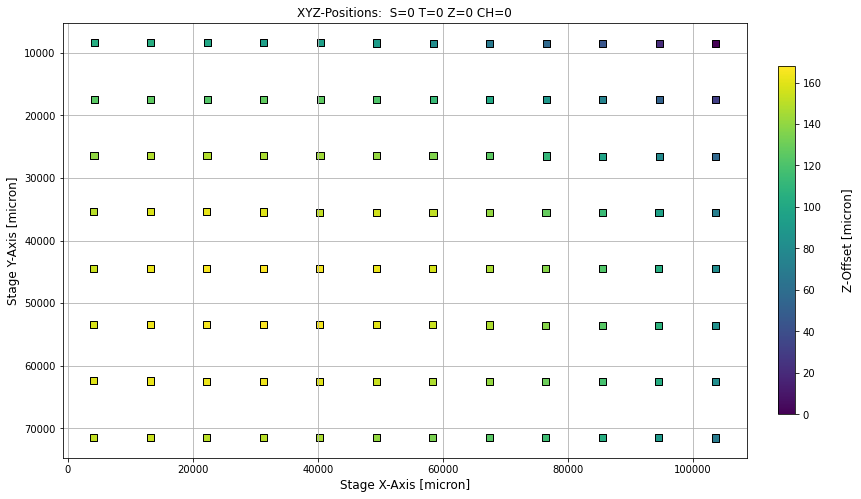

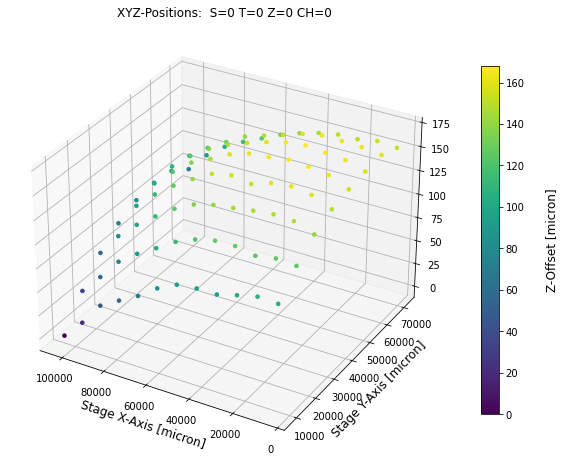

In [17]:
if plot_type == 'mpl':
    # display the XYZ positions using matplotlib
    fig1, fig2 = vt.scatterplot_mpl(planetable_filtered,
                                    S=S, T=T, Z=Z, C=C,
                                    msz2d=msz2d,
                                    normz=normz,
                                    fig1savename=fig1savename,
                                    fig2savename=fig2savename,
                                    msz3d=msz3d)
    # show the figure
    plt.show()

###########################################################
    
if plot_type == 'html':
    # display the XYZ positions using plotly
    fig1, fig2 = vt.scatterplot_plotly(planetable_filtered,
                                       S=S, T=T, Z=Z, C=C,
                                       msz2d=msz2d,
                                       normz=normz,
                                       fig1savename=fig1savename,
                                       fig2savename=fig2savename,
                                       msz3d=msz3d)
    
    # show the plotly charts
    plotly.offline.init_notebook_mode(connected=True)
    plotly.offline.iplot(fig1, filename='surfacemap2d')
    plotly.offline.iplot(fig2, filename='surfacemap3d')

In [13]:
# write the planetable to a csv
print('Write to CSV File : ', filename)
csvfile = czt.save_planetable(planetable, filename,
                              separator=separator,
                              index=False)

Write to CSV File :  testwell96_PlaneTable.csv
